## Diabete Feature Engineering

Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

### Değişkenler

Pregnancies: Hamilelik sayısı
Glucose: Glikoz
BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
SkinThickness: Cilt Kalınlığı
Insulin: İnsülin.
BMI: Beden kitle indeksi.
DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
Age: Yaş (yıl)
Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

## Gerekli Kütüphane ve Fonksiyonlar

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


df = pd.read_csv("Diabete_Feature_Engineering\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## GÖREV 1: KEŞİFCİ VERİ ANALİZİ

Adım 1: Genel resmi inceleyiniz.
Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.
Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
Adım 5: Aykırı gözlem analizi yapınız.
Adım 6: Eksik gözlem analizi yapınız.
Adım 7: Korelasyon analizi yapınız.

**GENEL RESİM**

In [4]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(90, '~'))
    print("%d rows and %d columns" % dataframe.shape)
    print(" SIZE ".center(90, '~'))
    print(dataframe.size)
    print(" TYPES ".center(90, '~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(90, '~'))
    print(dataframe.head(head))
    print(" TAIL ".center(90, '~'))
    print(dataframe.tail(head))
    print(" NA ".center(90, '~'))
    print(dataframe.isna().sum())
    print(" DP ".center(90, '~'))
    print(dataframe.duplicated().sum())
    print(" DESC ".center(90, '~'))
    quantiles = dataframe.describe([0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95]).T
    quantiles['IQR'] = quantiles['75%'] - quantiles['25%']
    print(quantiles)

check_df(df, head=2)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
768 rows and 9 columns
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SIZE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6912
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   

   DiabetesPedigreeFunction  Age  Outcome  
0     

**NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI**

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


**KATEGORİK DEĞİŞKENLERİN ANALİZİ**

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


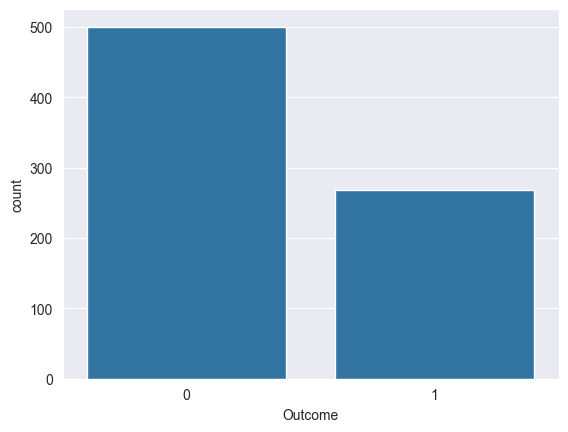

In [9]:
def cat_summary_l(dataframe, cat_cols, plot=False):
    for col_name in cat_cols:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")
        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show()

cat_summary_l(df, cat_cols, plot=True)

**NUMERİK DEĞİŞKENLERİN ANALİZİ**

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


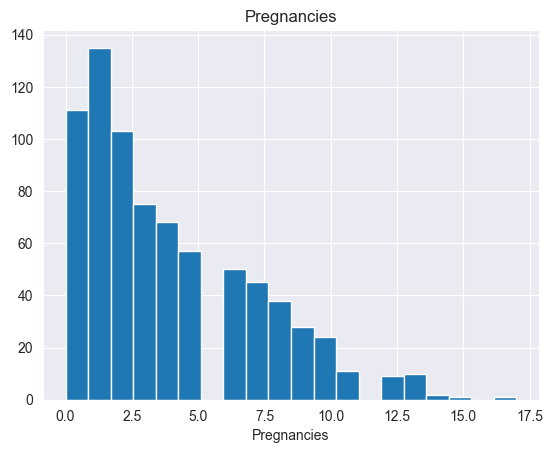

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


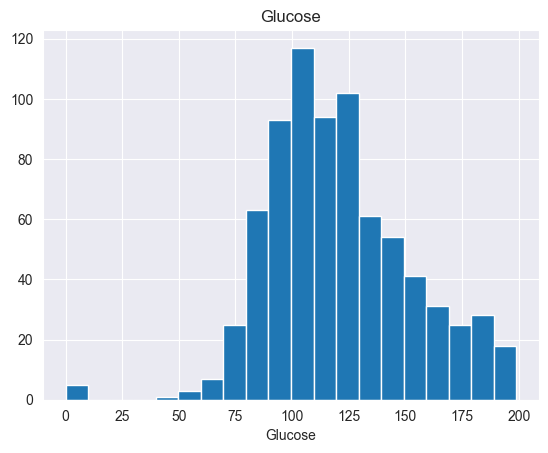

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


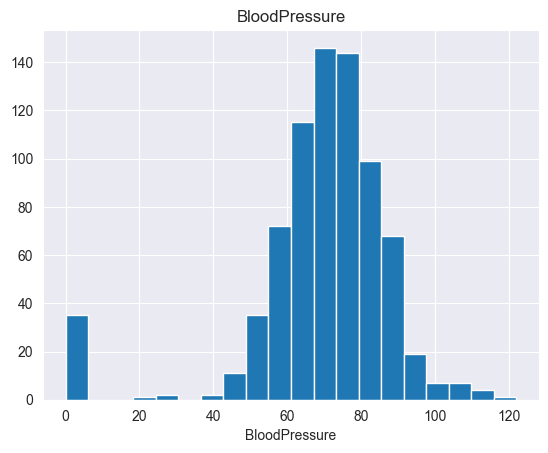

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


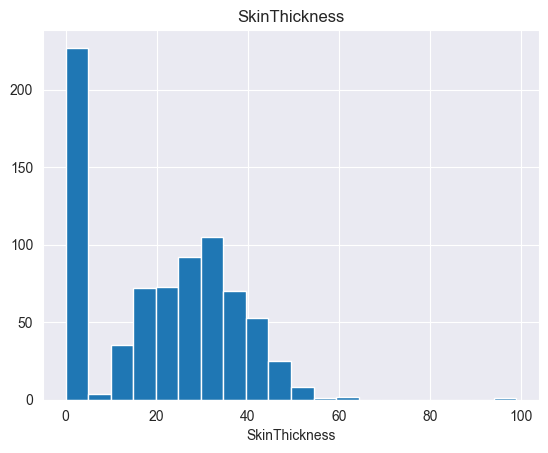

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


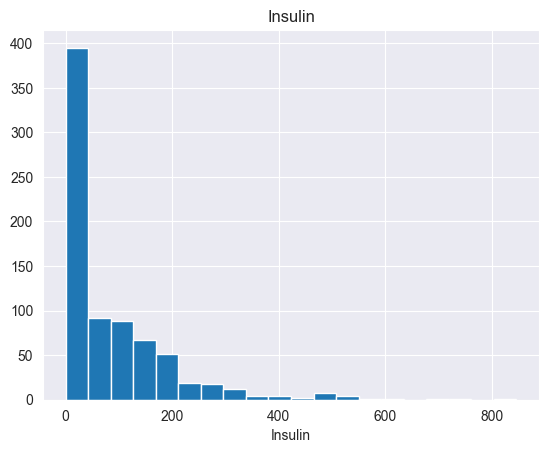

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


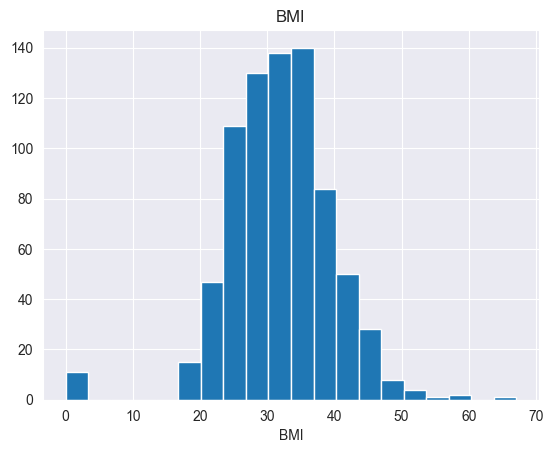

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


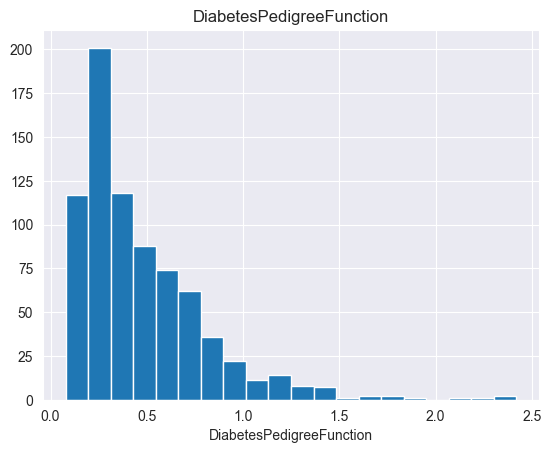

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


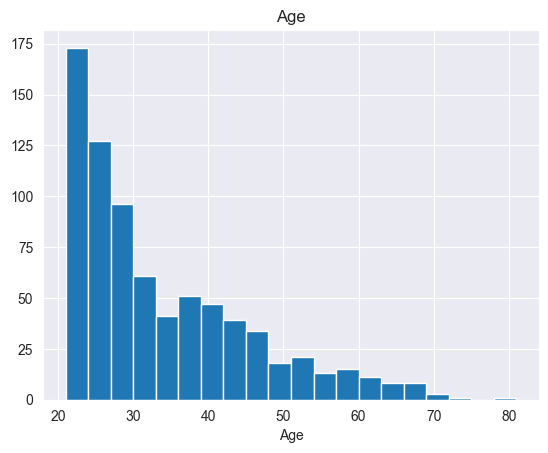

In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

**NUMERİK DEĞİŞKENLERİN TARGET'A GÖRE ANALİZİ**

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067


**KORELASYON**

Korelasyon, olasılık kuramı ve istatistikte iki rassal değişken arasındaki doğrusal ilişkinin yönünü ve gücünü belirtir

In [13]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


**Korelasyon Matrisi**

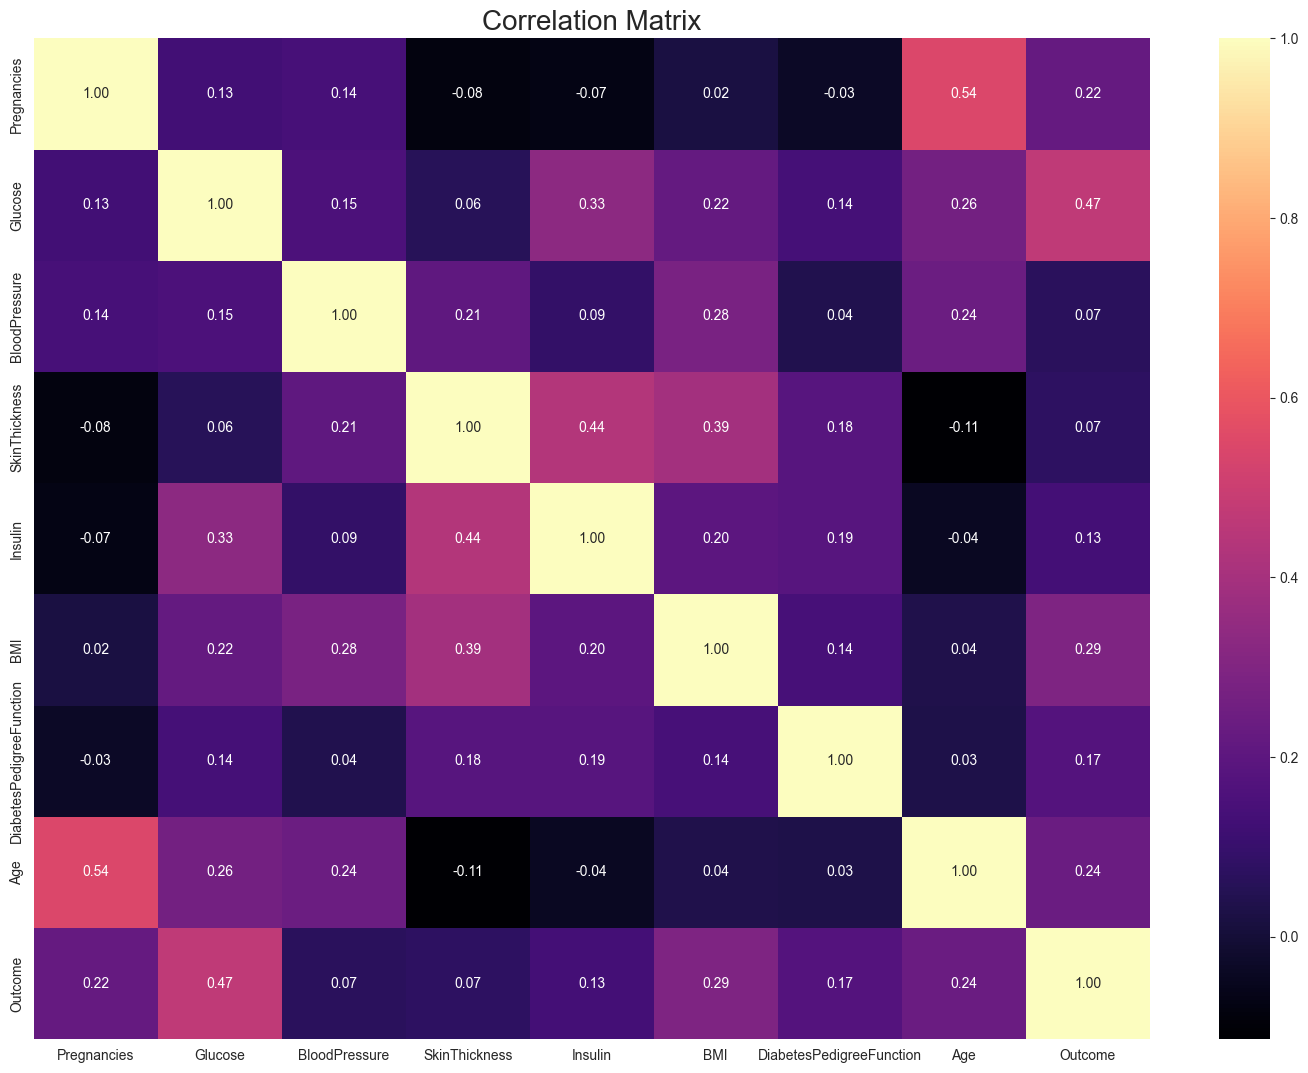

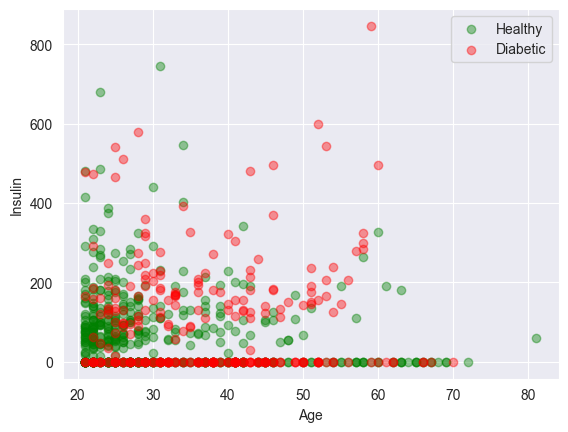

In [12]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()


diabetic = df[df.Outcome == 1]
healthy = df[df.Outcome == 0]

plt.scatter(healthy.Age, healthy.Insulin, color="green", label="Healthy", alpha = 0.4)
plt.scatter(diabetic.Age, diabetic.Insulin, color="red", label="Diabetic", alpha = 0.4)
plt.xlabel("Age")
plt.ylabel("Insulin")
plt.legend()
plt.show(block=True)

### BASE MODEL KURULUMU

In [14]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


Accuracy: 0.77
Recall: 0.706 # pozitif sınıfın ne kadar başarılı tahmin edildiği
Precision: 0.59 # Pozitif sınıf olarak tahmin edilen değerlerin başarısı
F1: 0.64
Auc: 0.75


## GÖREV 2: FEATURE ENGINEERING

Adım 1:  Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb.
değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri
0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere işlemleri uygulayabilirsiniz.

Adım 2: Yeni değişkenler oluşturunuz.

Adım 3:  Encoding işlemlerini gerçekleştiriniz.

Adım 4: Numerik değişkenler için standartlaştırma yapınız.

Adım 5: Model oluşturunuz.

__EKSİK DEĞER ANALİZİ__

Bir bireyde 'Pregnancies' ve 'Outcome' değişkenleri hariç olmak üzere, diğer değişkenlerin (örneğin, 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' gibi) değerleri biyolojik ve klinik açıdan 0 olamaz. Bu, bu değişkenlerin normal fizyolojik ve sağlık durumlarında belirli bir minimum değere sahip olması gerektiği anlamına gelir. Örneğin, bir bireyde glikoz veya kan basıncı değeri teorik olarak 0 olamaz, çünkü bu durumlar yaşamla bağdaşmaz. Bu nedenle, veri setinde bu değişkenler için kaydedilen 0 değerleri, muhtemelen eksik veya hatalı veri girişlerini temsil etmektedir. Dolayısıyla, veri analizi ve modelleme sürecinde bu 0 değerlerinin doğru bir şekilde ele alınması önemlidir. Bu bağlamda, bu tür potansiyel olarak hatalı 0 kayıtlarının 'NaN' (Not a Number) olarak işaretlenmesi ve sonrasında uygun veri imputasyon teknikleri ile yerlerinin doldurulması önerilir. Bu yaklaşım, modelin veri setinin gerçek dünya durumunu daha doğru bir şekilde yansıtmasını sağlayarak analizlerin güvenilirliğini artıracaktır

In [17]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.

In [18]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

2.Yöntem

In [19]:
for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)

**Eksik Gözlem Analizi**

In [20]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [21]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


**Eksik Değerlerin Doldurulması**

In [22]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**AYKIRI DEĞER ANALİZİ**

In [23]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

**Aykırı Değer Analizi ve Baskılama İşlemi**

In [29]:
print("#### BEFORE ####")
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
print("\n" + "#" * 20 + "\n")        
print("#### AFTER ####")
for col in df.columns:
    print(col, check_outlier(df, col))

#### BEFORE ####
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False

####################

####AFTER####
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


**ÖZELLİK ÇIKARIMI**

In [30]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması**


In [31]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature


**BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez**

In [32]:
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese


**Glukoz degerini kategorik değişkene çevirme**

In [33]:
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal


**Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı**

In [34]:
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

**Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma**

In [35]:
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature


**İnsulin Değeri ile Kategorik değişken türetmek**

In [36]:
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

_Sıfır olan değerler DİKKAT!_

In [38]:
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])

**Kolonların büyültülmesi**

In [39]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,1036.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,170.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,137.000


### ENCODING

**Değişkenlerin tiplerine göre ayrılması işlemi**

In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


**LABEL ENCODING**

In [41]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,1036.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,170.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,22875.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,137.000


**One-Hot Encoding İşlemi ve cat_cols listesinin güncelleme işlemi**

In [42]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [43]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,1036.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,170.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1647.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,178.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,137.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### STANDARTLAŞTIRMA

In [44]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [45]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.914,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.913,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.203,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.896,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-0.982,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### MODELLEME

In [46]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.693
Precision: 0.64
F1: 0.67
Auc: 0.75


Base Model
Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75

### FEATURE IMPORTANCE

    Value                            Feature
1   0.144                            GLUCOSE
10  0.133                NEW_GLUCOSE*INSULIN
11  0.110            NEW_GLUCOSE*PREGNANCIES
6   0.096           DIABETESPEDIGREEFUNCTION
5   0.095                                BMI
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


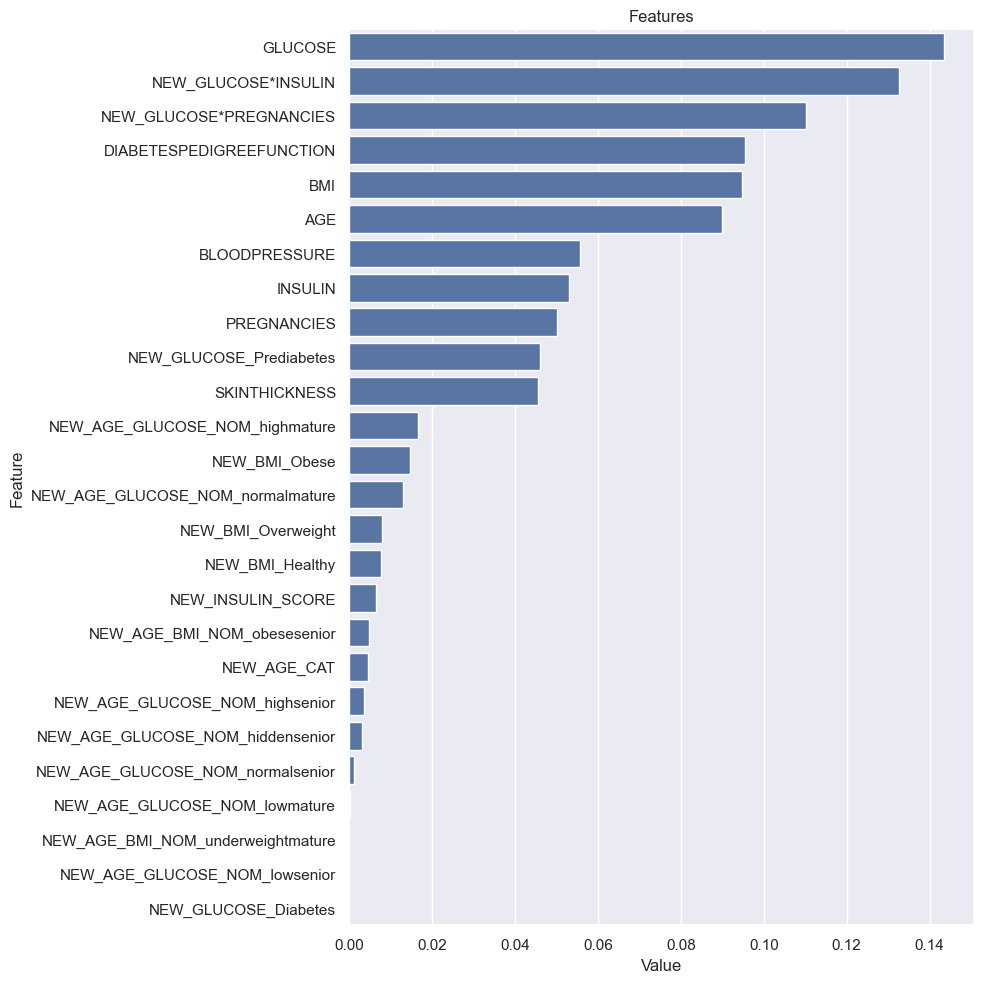

In [47]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

### HİPERPARAMETRE OPTİMİZASYONU 

In [50]:
def objective(trial):
    params =  {'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
               'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, 30, None]),
               'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=5),
               'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)}
    # Define the hyperparameters to be optimized

    # Train the model with the selected hyperparameters and calculate the accuracy score
    model = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = scores.mean()

    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-29 15:58:07,775] A new study created in memory with name: no-name-7a9d0bfc-8355-4e63-a9a5-cea11f265ced
[I 2023-11-29 15:58:09,303] Trial 0 finished with value: 0.765385946694358 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.765385946694358.
[I 2023-11-29 15:58:10,130] Trial 1 finished with value: 0.7692107995846313 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7692107995846313.
[I 2023-11-29 15:58:11,522] Trial 2 finished with value: 0.7616995500173072 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7692107995846313.
[I 2023-11-29 15:58:12,652] Trial 3 finished with value: 0.7710107303565248 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 3 with value:

In [51]:
print('Best trial score:', study.best_value)
print('Best trial params:', study.best_params)

Best trial score: 0.7822083766008999
Best trial params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 1}


In [52]:
rf_model = RandomForestClassifier(random_state=42, n_estimators= 150, max_depth= None, min_samples_split= 7, min_samples_leaf= 3).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7878787878787878

In [54]:
def xgboost_objective(trial):
    params = {'n_estimators': trial.suggest_int('n_estimators', 50, 200),
              'max_depth': trial.suggest_int('max_depth', 5, 30, log=True),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)}
    # Train the model with the selected hyperparameters and calculate the accuracy score
    model = XGBClassifier(random_state=42, **params)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = scores.mean()

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(xgboost_objective, n_trials=100)
xgb_best_params = study.best_params

[I 2023-11-29 16:01:31,608] A new study created in memory with name: no-name-2baa92e3-d2be-427c-ad02-943e862039ce
[I 2023-11-29 16:01:32,245] Trial 0 finished with value: 0.7543267566632053 and parameters: {'n_estimators': 125, 'max_depth': 16, 'learning_rate': 0.0904382065057797, 'min_child_weight': 2}. Best is trial 0 with value: 0.7543267566632053.
[I 2023-11-29 16:01:32,592] Trial 1 finished with value: 0.6517826237452404 and parameters: {'n_estimators': 87, 'max_depth': 11, 'learning_rate': 0.0033130207947601625, 'min_child_weight': 7}. Best is trial 0 with value: 0.7543267566632053.
[I 2023-11-29 16:01:33,104] Trial 2 finished with value: 0.7673416407061266 and parameters: {'n_estimators': 179, 'max_depth': 6, 'learning_rate': 0.0410387125663751, 'min_child_weight': 9}. Best is trial 2 with value: 0.7673416407061266.
[I 2023-11-29 16:01:33,444] Trial 3 finished with value: 0.7673589477327795 and parameters: {'n_estimators': 122, 'max_depth': 5, 'learning_rate': 0.0620699560562599

In [55]:
print('Best trial score:', study.best_value)
print('Best trial params:', study.best_params)

Best trial score: 0.7934752509518864
Best trial params: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.0071944637207407335, 'min_child_weight': 3}
